In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

In [2]:
# loading the chestmnist dataset
data_path = "data"
data = np.load(f"{data_path}/chestmnist_224.npz")

train_images = data['train_images']
train_labels = data['train_labels']

validation_images = data['val_images']
validation_labels = data['val_labels']

test_images = data['test_images']
test_labels = data['test_labels']


In [3]:
print(data)

NpzFile 'data/chestmnist_224.npz' with keys: train_images, train_labels, val_images, val_labels, test_images...


In [4]:
print(train_images[0].shape)

(224, 224)


In [5]:
print(type(train_images))

<class 'numpy.ndarray'>


In [6]:
print(f"The shape of train images: {train_images.shape}, train labels: {train_labels.shape}")
print(f"The shape of validation images: {validation_images.shape}, validation labels: {validation_labels.shape}")
print(f"The shape of test images: {test_images.shape}, test labels: {test_labels.shape}")


The shape of train images: (78468, 224, 224), train labels: (78468, 14)
The shape of validation images: (11219, 224, 224), validation labels: (11219, 14)
The shape of test images: (22433, 224, 224), test labels: (22433, 14)


In [7]:
class ChestMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self): 
        return len(self.images) # number of samples
    
    def __getitem__(self, idx):
        img = self.images[idx]

        if self.transform: # apply transformations
            img = self.transform(img)

        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float)
        
        return img, label

In [8]:
from torchvision import transforms # to apply transformations to the images

transforms_with_augmentation = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.RandomRotation(degrees=10), # Randomly rotates the image between -10 and +10 degrees
    transforms.Normalize((0.5,), (0.5,)) # normalize the images
])

transforms = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize((0.5,), (0.5,)) # normalize the images
])

In [9]:
train_dataset = ChestMNISTDataset(train_images, train_labels, transform=transforms_with_augmentation)
validation_dataset = ChestMNISTDataset(validation_images, validation_labels, transform=transforms)
test_dataset = ChestMNISTDataset(test_images, test_labels, transform=transforms)

In [10]:
# creating the dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
model = models.resnet18(weights=None) # not pretrained
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # Change input channels from 3 to 1 (grayscale images)
model.fc = nn.Linear(512, 14)  # final fully connected layer

model = model.to(device) # move the model to the GPU

In [13]:
loss = nn.BCEWithLogitsLoss()  # for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
training_epochs = 10

In [15]:
import time
from sklearn.metrics import roc_auc_score

train_losses = []
train_aucs = []
train_accs = []
val_losses = []
val_aucs = []
val_accs = []
train_epoch_times = []

for epoch in range(training_epochs):
    model.train() # set the model to training mode
    total_loss = 0
    all_outputs = []
    all_targets = []
    
    start_time = time.time()

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        inputs, targets = inputs.to(device), targets.to(device) # move to the GPU
        optimizer.zero_grad() # zero the gradients
        outputs = model(inputs) # forward pass
        loss_value = loss(outputs, targets) # compute loss
        loss_value.backward() # backward pass
        optimizer.step() # update weights

        total_loss += loss_value.item()
        all_outputs.append(torch.sigmoid(outputs).detach().cpu()) # store outputs after applying sigmoid
        all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs).numpy() # concatenate all predictions to a single numpy array
    all_targets = torch.cat(all_targets).numpy()
    
    avg_loss = total_loss / len(train_loader) # average loss for the epoch, len(train_loader) gives number of batches
    auc = roc_auc_score(all_targets, all_outputs, average='macro') # calculate AUC score
    train_acc = ((all_outputs > 0.5) == all_targets).mean()
    
    train_losses.append(avg_loss)
    train_aucs.append(auc)
    train_accs.append(train_acc)
    
    # Validation
    model.eval() # sets the model to evaluation mode
    val_total_loss = 0
    val_outputs = []
    val_targets = []
    
    epoch_time = time.time() - start_time
    train_epoch_times.append(epoch_time)

    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss_value = loss(outputs, targets)
            val_total_loss += val_loss_value.item()
            val_outputs.append(torch.sigmoid(outputs).cpu())
            val_targets.append(targets.cpu())
    
    val_outputs = torch.cat(val_outputs).numpy()
    val_targets = torch.cat(val_targets).numpy()
    
    val_avg_loss = val_total_loss / len(validation_loader)
    val_auc = roc_auc_score(val_targets, val_outputs, average='macro')
    val_acc = ((val_outputs > 0.5) == val_targets).mean()
    
    val_losses.append(val_avg_loss)
    val_aucs.append(val_auc)
    val_accs.append(val_acc)

    if (epoch + 1) >= 3:
        torch.save(model.state_dict(), f"models/model_epoch_{epoch+1}.pt")
    
    print(f"Epoch [{epoch+1}/{training_epochs}], Train Loss: {avg_loss:.4f}, Train AUC: {auc:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_avg_loss:.4f}, Val AUC: {val_auc:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

Epoch [1/10], Train Loss: 0.1744, Train AUC: 0.6512, Train Acc: 0.9483, Val Loss: 0.1724, Val AUC: 0.6943, Val Acc: 0.9493, Time: 238.10s
Epoch [2/10], Train Loss: 0.1659, Train AUC: 0.7211, Train Acc: 0.9487, Val Loss: 0.1661, Val AUC: 0.7541, Val Acc: 0.9488, Time: 294.90s
Epoch [3/10], Train Loss: 0.1619, Train AUC: 0.7504, Train Acc: 0.9489, Val Loss: 0.1587, Val AUC: 0.7651, Val Acc: 0.9493, Time: 228.57s
Epoch [4/10], Train Loss: 0.1588, Train AUC: 0.7679, Train Acc: 0.9491, Val Loss: 0.1586, Val AUC: 0.7764, Val Acc: 0.9494, Time: 234.91s
Epoch [5/10], Train Loss: 0.1563, Train AUC: 0.7815, Train Acc: 0.9493, Val Loss: 0.1572, Val AUC: 0.7804, Val Acc: 0.9487, Time: 233.76s
Epoch [6/10], Train Loss: 0.1543, Train AUC: 0.7914, Train Acc: 0.9495, Val Loss: 0.1543, Val AUC: 0.7938, Val Acc: 0.9495, Time: 228.56s
Epoch [7/10], Train Loss: 0.1519, Train AUC: 0.8039, Train Acc: 0.9496, Val Loss: 0.1554, Val AUC: 0.7898, Val Acc: 0.9492, Time: 230.14s
Epoch [8/10], Train Loss: 0.1501, 

In [22]:
print(epoch)

9


In [ ]:
print(f"training_epochs: {training_epochs}")
print(f"train_losses length: {len(train_losses)}")
print(f"train_aucs length: {len(train_aucs)}")
print(f"train_accs length: {len(train_accs)}")
print(f"val_losses length: {len(val_losses)}")
print(f"val_aucs length: {len(val_aucs)}")
print(f"val_accs length: {len(val_accs)}")
print(f"train_epoch_times length: {len(train_epoch_times)}")

training_epochs: 10
train_losses length: 10
train_aucs length: 10
train_accs length: 11
val_losses length: 10
val_aucs length: 10
val_accs length: 10
train_epoch_times length: 10


In [33]:
train_accs = train_accs[:-1]  # Adjusting the length to match other metrics

In [ ]:
import pandas as pd

# Create DataFrame with all metrics
metrics_df = pd.DataFrame({
    'epoch': range(1, training_epochs + 1),
    'train_loss': train_losses,
    'train_auc': train_aucs,
    'train_acc': train_accs,  # Adjusted to match lengths
    'val_loss': val_losses,
    'val_auc': val_aucs,
    'val_acc': val_accs,
    'epoch_time': train_epoch_times
})

# Save to CSV
metrics_df.to_csv('training_metrics.csv', index=False)

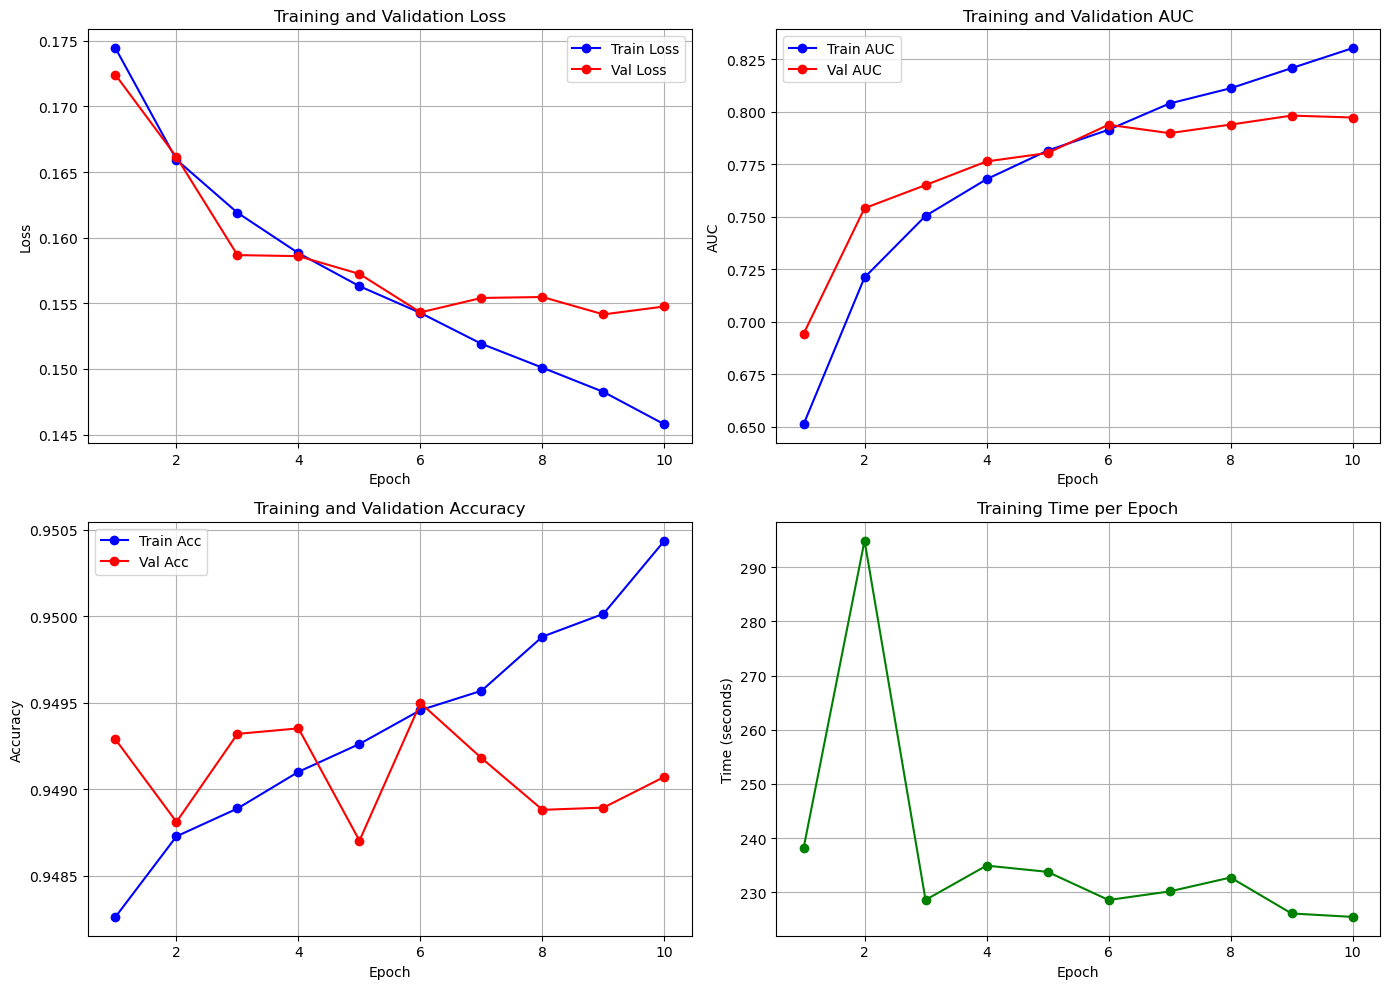

In [34]:
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = range(1, len(train_losses) + 1)

# Plot 1: Loss
axes[0, 0].plot(epochs, train_losses, 'b-o', label='Train Loss')
axes[0, 0].plot(epochs, val_losses, 'r-o', label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: AUC
axes[0, 1].plot(epochs, train_aucs, 'b-o', label='Train AUC')
axes[0, 1].plot(epochs, val_aucs, 'r-o', label='Val AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Training and Validation AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Accuracy
axes[1, 0].plot(epochs, train_accs, 'b-o', label='Train Acc')
axes[1, 0].plot(epochs, val_accs, 'r-o', label='Val Acc')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Training and Validation Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Epoch Time
axes[1, 1].plot(epochs, train_epoch_times, 'g-o')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Time (seconds)')
axes[1, 1].set_title('Training Time per Epoch')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# The best model is at epoch 6

In [20]:
# calculate test accuracy

model.eval() # set the model to evaluation mode
with torch.no_grad():
    all_predictions = []
    all_labels = []
    
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs) > 0.5
        
        all_predictions.append(predictions.cpu())
        all_labels.append(targets.cpu())
    
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    
    test_accuracy = (all_predictions == all_labels).float().mean().item()
    print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9476
